In [ ]:
from google.colab import files
from google.colab import drive
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

# path to zip file containing the dataset in Google Drive
!cp '/content/drive/My Drive/Database.zip' .

# extract the Database folder to the current directory
!unzip Database.zip -d ./

Mounted at /content/drive
Archive:  Database.zip
   creating: ./Database/
  inflating: ./__MACOSX/._Database   
  inflating: ./Database/Label.txt    
  inflating: ./__MACOSX/Database/._Label.txt  
  inflating: ./Database/.DS_Store    
  inflating: ./__MACOSX/Database/._.DS_Store  
   creating: ./Database/Image/
  inflating: ./__MACOSX/Database/._Image  
  inflating: ./Database/Image/6_P0_R30_00054.jpg  
  inflating: ./__MACOSX/Database/Image/._6_P0_R30_00054.jpg  
  inflating: ./Database/Image/6_P10_R20_00027.jpg  
  inflating: ./__MACOSX/Database/Image/._6_P10_R20_00027.jpg  
  inflating: ./Database/Image/6_P10_R20_00033.jpg  
  inflating: ./__MACOSX/Database/Image/._6_P10_R20_00033.jpg  
  inflating: ./Database/Image/6_P0_R30_00040.jpg  
  inflating: ./__MACOSX/Database/Image/._6_P0_R30_00040.jpg  
  inflating: ./Database/Image/6_P20_R50_00022.jpg  
  inflating: ./__MACOSX/Database/Image/._6_P20_R50_00022.jpg  
  inflating: ./Database/Image/6_P50_R60_00007.jpg  
  inflating: ./__MACO

In [ ]:
label_path = '/content/Database/Label.txt'
image_folder = '/content/Database/Image'

# map the images with the label.txt
labels = pd.read_csv(label_path,
                     delimiter=' ',
                     header=None,
                     names=['Image', 'Pitch', 'Roll', 'Depth'])

print("First and last few rows of the labels:")
print(labels.head())
print(labels.tail())

First and last few rows of the labels:
               Image  Pitch  Roll     Depth
0  6_P0_R0_00001.jpg      0     0  0.611818
1  6_P0_R0_00002.jpg      0     0  0.693017
2  6_P0_R0_00003.jpg      0     0  0.457814
3  6_P0_R0_00004.jpg      0     0  0.105780
4  6_P0_R0_00005.jpg      0     0  0.296676
                    Image  Pitch  Roll     Depth
2011  6_P70_R70_00052.jpg     70    70  0.003353
2012  6_P70_R70_00053.jpg     70    70  0.958107
2013  6_P70_R70_00054.jpg     70    70  0.016327
2014  6_P70_R70_00055.jpg     70    70  0.000000
2015  6_P70_R70_00056.jpg     70    70  0.214759


In [ ]:
images = {}

# Loop through image filenames in Label.txt and load them
for img_name in labels['Image']:
    img_path = os.path.join(image_folder, img_name)
    try:
        images[img_name] = Image.open(img_path)  # Open the image
    except FileNotFoundError:
        print(f"Warning: {img_name} not found in {image_folder}")

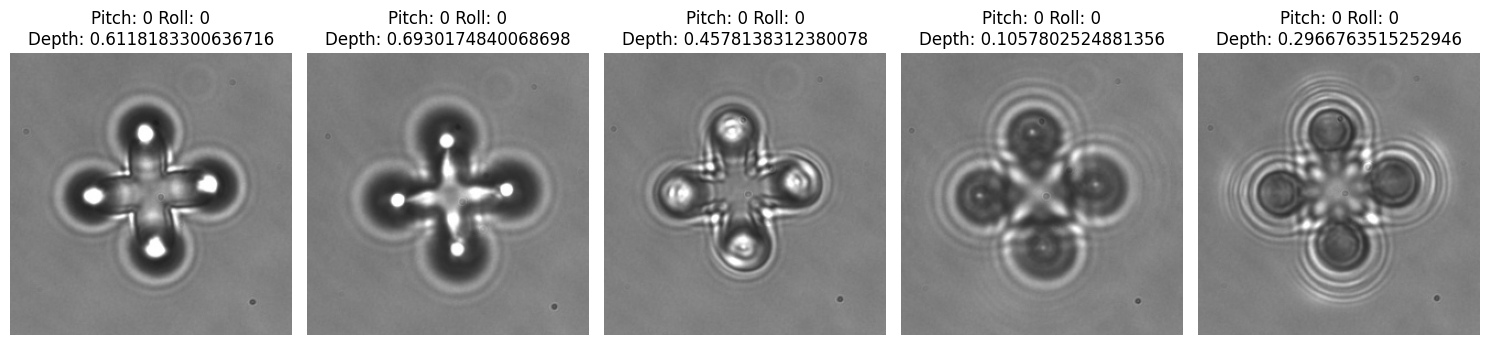

In [ ]:
# Displaying few sample images with their labels
plt.figure(figsize=(15, 5))

for i in range(5):
    sample_image_path = labels['Image'].iloc[i]
    sample_pitch = labels['Pitch'].iloc[i]
    sample_roll = labels['Roll'].iloc[i]
    sample_depth = labels['Depth'].iloc[i]

    sample_image_path = os.path.join(image_folder, sample_image_path)

    image = Image.open(sample_image_path)

    plt.subplot(1, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Pitch: {sample_pitch} Roll: {sample_roll}\nDepth: {sample_depth}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# STANDARDISATION OF DEPTH VALUES

depth_mean = labels['Depth'].mean()
depth_std = labels['Depth'].std()

# Create a new column for standardized Depth
labels['Depth_standardized'] = (labels['Depth'] - depth_mean) / depth_std

print("Depth standardization statistics:")
print(f"Mean of standardized Depth: {labels['Depth_standardized'].mean():.2f}")
print(f"Standard deviation of standardized Depth: {labels['Depth_standardized'].std():.2f}")

print(labels[['Depth', 'Depth_standardized']].head())

Depth standardization statistics:
Mean of standardized Depth: 0.00
Standard deviation of standardized Depth: 1.00
      Depth  Depth_standardized
0  0.611818            0.307041
1  0.693017            0.544485
2  0.457814           -0.143301
3  0.105780           -1.172724
4  0.296676           -0.614502


In [ ]:
print(labels.head())
print(labels.tail())

               Image  Pitch  Roll     Depth  Depth_standardized
0  6_P0_R0_00001.jpg      0     0  0.611818            0.307041
1  6_P0_R0_00002.jpg      0     0  0.693017            0.544485
2  6_P0_R0_00003.jpg      0     0  0.457814           -0.143301
3  6_P0_R0_00004.jpg      0     0  0.105780           -1.172724
4  6_P0_R0_00005.jpg      0     0  0.296676           -0.614502
                    Image  Pitch  Roll     Depth  Depth_standardized
2011  6_P70_R70_00052.jpg     70    70  0.003353           -1.472242
2012  6_P70_R70_00053.jpg     70    70  0.958107            1.319664
2013  6_P70_R70_00054.jpg     70    70  0.016327           -1.434305
2014  6_P70_R70_00055.jpg     70    70  0.000000           -1.482048
2015  6_P70_R70_00056.jpg     70    70  0.214759           -0.854047


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
import seaborn as sns

In [ ]:
class DepthDataset(Dataset):
    def __init__(self, labels_df, image_folder, transform=None):
        self.labels_df = labels_df
        self.transform = transform
        self.image_folder = image_folder

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = self.labels_df.iloc[idx]['Image']
        # Now we directly use the standardized depth
        depth = self.labels_df.iloc[idx]['Depth_standardized']

        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert("L")  # Grayscale
        if self.transform:
            image = self.transform(image)

        depth = torch.tensor(depth, dtype=torch.float32)
        return image, depth

In [ ]:
# SPLITTING the data into 60:20:20

train_df, test_df = train_test_split(labels,
                                     test_size=0.2,
                                     random_state=42)

train_df, val_df = train_test_split(train_df,
                                    test_size=0.25,
                                    random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Training samples: 1209
Validation samples: 403
Test samples: 404


In [ ]:
# AUGMENTATION

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),                  # Convert to 3 channels for resnet
    transforms.Resize((224, 224)),                                # Resize to 224x224
    transforms.RandomRotation(1),                                 # Random rotation within 5 degrees
    transforms.ColorJitter(brightness=0.3),                       # Random brightness adjustment
    transforms.ToTensor(),                                        # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],              # Normalize for resnet
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = DepthDataset(train_df, image_folder, transform=train_transform)
val_dataset = DepthDataset(val_df, image_folder, transform=val_test_transform)
test_dataset = DepthDataset(test_df, image_folder, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
for images, depths in train_loader:
    print("Image shape:", images.shape)
    print("Depth shape:", depths.shape)
    print("Depth mean (sample):", depths.mean().item())
    print("Depth std (sample):", depths.std().item())
    break

Image shape: torch.Size([32, 3, 224, 224])
Depth shape: torch.Size([32])
Depth mean (sample): 0.04220506548881531
Depth std (sample): 1.057639718055725


In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

class DepthResNet50(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(DepthResNet50, self).__init__()
        weights = ResNet50_Weights.IMAGENET1K_V1
        self.base_model = resnet50(weights=weights)

        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, 1)  # single output for regression
        )

    def forward(self, x):
        return self.base_model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DepthResNet50(dropout_rate=0.3).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s]


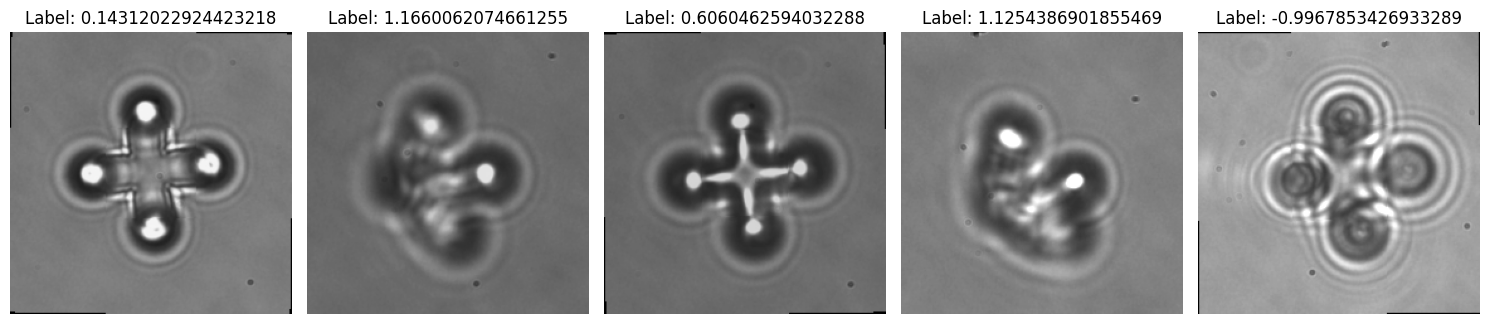

In [ ]:
# Function to display images
def show_augmented_images(dataloader, num_images=5):
    data_iter = iter(dataloader)  # Get an iterator for the DataLoader
    images, labels = next(data_iter)  # Get the first batch of images and labels

    # Denormalise images for visualization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    images = images * std + mean  # Reverse normalization

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        ax = axes[i]
        img = images[i].permute(1, 2, 0).numpy()  # Convert to HWC for Matplotlib
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"Label: {labels[i]}")
    plt.tight_layout()
    plt.show()

show_augmented_images(train_loader)

In [ ]:
criterion = nn.MSELoss()                                  # LOSS FUNCTION

optimizer = torch.optim.AdamW(model.parameters(),         # OPTIMSER AND LEARNING RATE
                              lr=1e-4,
                              weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=4,
                                            gamma=0.1)    # SCHEDULER FOR LEARNING RATE

In [ ]:
def train_model(model, train_loader, val_loader, epochs=10):
    # To store losses per epoch
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, depths in train_loader:
            images, depths = images.to(device), depths.to(device)

            optimizer.zero_grad()
            outputs = model(images).squeeze()  # [batch_size]
            loss = criterion(outputs, depths)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate average train loss
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, depths in val_loader:
                images, depths = images.to(device), depths.to(device)
                outputs = model(images).squeeze()
                loss = criterion(outputs, depths)
                val_loss += loss.item()

        # Calculate average validation loss
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Scheduler step
        scheduler.step()

        # Print epoch results
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}")

    # Plotting the training and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='red')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss per Epoch')
    plt.legend()
    plt.show()

Epoch [1/20], Train Loss: 0.2088, Validation Loss: 0.1896
Epoch [2/20], Train Loss: 0.1297, Validation Loss: 0.0327
Epoch [3/20], Train Loss: 0.1035, Validation Loss: 0.0492
Epoch [4/20], Train Loss: 0.0929, Validation Loss: 0.0260
Epoch [5/20], Train Loss: 0.0642, Validation Loss: 0.0152
Epoch [6/20], Train Loss: 0.0541, Validation Loss: 0.0137
Epoch [7/20], Train Loss: 0.0543, Validation Loss: 0.0136
Epoch [8/20], Train Loss: 0.0573, Validation Loss: 0.0136
Epoch [9/20], Train Loss: 0.0527, Validation Loss: 0.0141
Epoch [10/20], Train Loss: 0.0593, Validation Loss: 0.0190
Epoch [11/20], Train Loss: 0.0490, Validation Loss: 0.0139
Epoch [12/20], Train Loss: 0.0490, Validation Loss: 0.0123
Epoch [13/20], Train Loss: 0.0482, Validation Loss: 0.0122
Epoch [14/20], Train Loss: 0.0500, Validation Loss: 0.0121
Epoch [15/20], Train Loss: 0.0514, Validation Loss: 0.0131
Epoch [16/20], Train Loss: 0.0501, Validation Loss: 0.0122
Epoch [17/20], Train Loss: 0.0626, Validation Loss: 0.0130
Epoch 

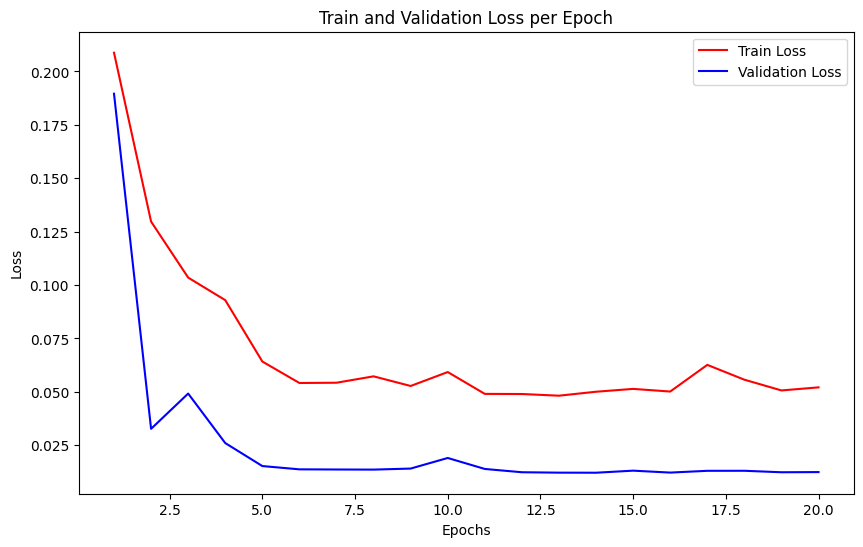

In [ ]:
train_model(model, train_loader, val_loader, epochs=20)

In [ ]:
def evaluate_model(model, test_loader, depth_mean, depth_std):
    model.eval()
    preds = []
    trues = []
    images_list = []  # To store a few sample images for visualization

    with torch.no_grad():
        for images, depths in test_loader:
            images = images.to(device)
            outputs = model(images).squeeze().cpu().numpy()
            true_depths = depths.cpu().numpy()

            # De-standardize predictions
            outputs_denorm = outputs * depth_std + depth_mean
            true_depths_denorm = true_depths * depth_std + depth_mean

            preds.extend(outputs_denorm)
            trues.extend(true_depths_denorm)

            # Store images and labels for visualization (only first batch for simplicity)
            if len(images_list) < 5:  # Show first 5 images
                images_list.extend(images.cpu().numpy())

    preds = np.array(preds)
    trues = np.array(trues)

    # Calculate MSE, RMSE, and MAE
    mse = ((preds - trues) ** 2).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(preds - trues).mean()

    print(f"Test MSE: {mse:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")

    # De-normalize the images for visualization
    def denormalize(image, mean, std):
        mean = np.array(mean)
        std = np.array(std)
        image = (image * std[:, None, None]) + mean[:, None, None]
        return np.clip(image, 0, 1)  # Clip to range [0, 1]

    # Visualize a few samples of actual vs predicted values
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    for i in range(5):
        ax = axes[i]
        img = images_list[i]

        # De-normalize the image
        mean = [0.485, 0.456, 0.406]  # Mean used in normalization
        std = [0.229, 0.224, 0.225]  # Std used in normalization
        img = denormalize(img, mean, std)
        img = img.transpose(1, 2, 0)  # Convert from CxHxW to HxWxC

        ax.imshow(img)
        ax.set_title(f"True: {trues[i]:.5f}\nPred: {preds[i]:.5f}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

Test MSE: 0.0014
Test RMSE: 0.0378
Test MAE: 0.0271


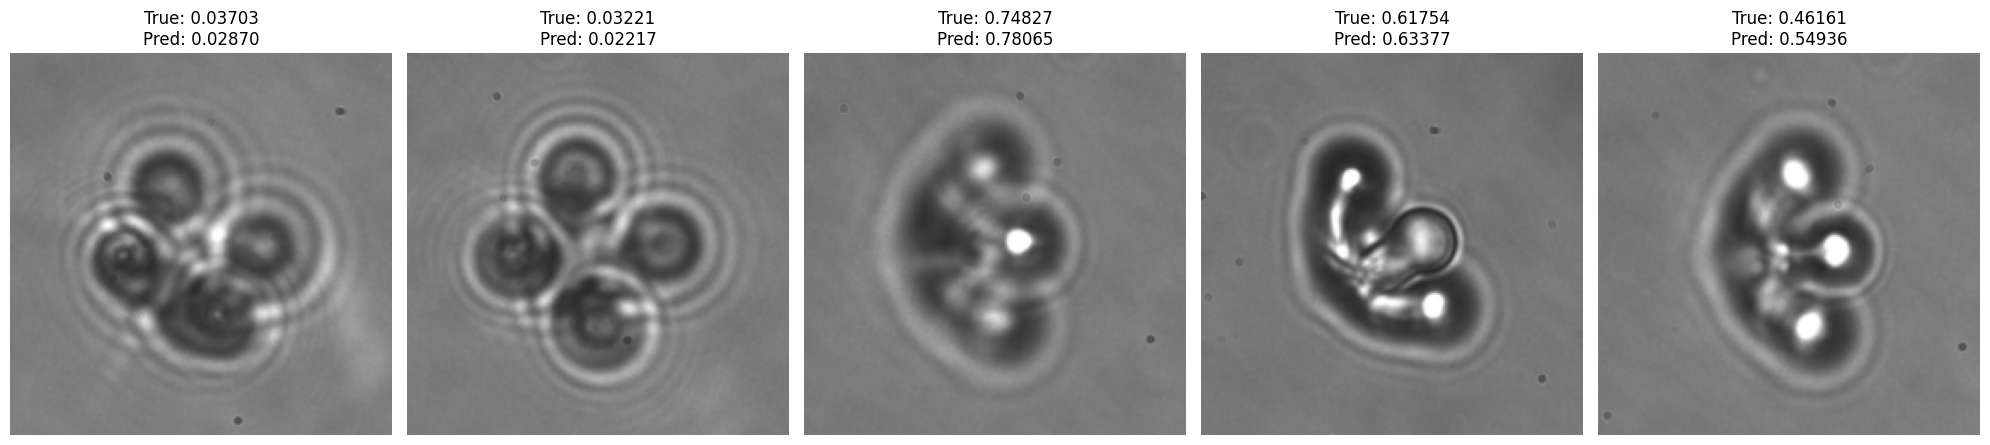

In [ ]:
evaluate_model(model, test_loader, depth_mean, depth_std)

In [ ]:
model_path = "depth_estimation_resnet_gurmeher.pth"
torch.save(model.state_dict(), model_path)

import json
depth_stats = {"depth_mean": float(depth_mean), "depth_std": float(depth_std)}
with open("depth_stats.json", "w") as f:
    json.dump(depth_stats, f)

In [ ]:
from google.colab import files

files.download("depth_estimation_resnet_gurmeher.pth")
files.download("depth_stats.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>